In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [24]:
from edit_penalty import EditPenaltyCollection, EditPenaltyCollectionAnalyser
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
from matplotlib.transforms import ScaledTranslation
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame, Series
from typing import Iterable, Optional, Tuple, Literal

plt.style.use("ggplot")
plt.style.use("my.mplstyle")


Bad key figure.titlecolor in file my.mplstyle, line 10 ('figure.titlecolor: 212529')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [3]:
RESULTS_DIR = PROJECT_ROOT/"analysis_results"

LARGELY_SAMPLED_EPITOPES = pd.read_csv("analysis_results/CDR3 Levenshtein/one_vs_rest_200_shot_nn.csv").epitope.unique()

NUM_SHOTS_OF_INTEREST = [1,2,5,10,20,50,100,200]

SAVE_FORMAT = "pdf"

In [4]:
class ModelToPlot:
    def __init__(self, model_name: str, colour: Optional[str] = None, marker: Optional[str] = None, zorder: Optional[float] = 1.5, ten_x: bool = False) -> None:
        self.name = model_name
        self.colour = colour
        self.marker = marker
        self.zorder = zorder
        self.ten_x = ten_x
    
    def load_data(self, task_name: str) -> DataFrame:
        if self.ten_x:
            path_to_csv = RESULTS_DIR/"10x"/self.name/f"{task_name}.csv"
        else:
            path_to_csv = RESULTS_DIR/self.name/f"{task_name}.csv"
        return pd.read_csv(path_to_csv)
    
    def load_epc_analyser(self) -> EditPenaltyCollectionAnalyser:
        path_to_epc_state_dict = RESULTS_DIR/self.name/"epc_state_dict.pkl"
        with open(path_to_epc_state_dict, "rb") as f:
            epc = EditPenaltyCollection.from_save(f)
        return EditPenaltyCollectionAnalyser(epc)

In [97]:
def generate_ovr_summary_figure(anchor_model: ModelToPlot, comparison_models: Iterable[ModelToPlot], ks: Iterable[int], epitopes: Iterable[str], ncols: int) -> Figure:
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(6.5,2.5))

    all_models = [anchor_model, *comparison_models]
    plot_ovr_performance_summary(all_models, ks, epitopes, axs[0])
    plot_ovr_delta_summary(anchor_model, comparison_models, ks, epitopes, axs[1])

    for ax, label in zip(axs, ("a", "b")):
        trans = ScaledTranslation(-60/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')

    fig.legend(loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=ncols)
    fig.tight_layout()
    return fig

def plot_ovr_performance_summary(models: Iterable[ModelToPlot], ks: Iterable[int], epitopes: Iterable[str], axes: Axes, labels: bool = True, legend: bool = False) -> None:
    for model in models:
        raw_results = [model.load_data(get_ovr_task_name(k)) for k in ks]
        average_auc_per_epitope = [df.groupby("epitope").aggregate({"auc": "mean"}) for df in raw_results]
        avg_aucs = [s[s.index.isin(epitopes)].mean().item() for s in average_auc_per_epitope]

        axes.plot(avg_aucs, model.marker, c=model.colour, label=model.name, zorder=model.zorder)
    
    if labels:
        axes.set_ylabel("Macro AUROC")
        axes.set_xlabel("Number of Shots")
    
    axes.set_xticks(range(len(ks)), ks)

    if legend:
        axes.legend()

def get_ovr_task_name(k: int) -> str:
    if k == 1:
        return "one_vs_rest_1_shot"
    return f"one_vs_rest_{k}_shot_nn"

def plot_ovr_delta_summary(anchor_model: ModelToPlot, comparison_models: Iterable[ModelToPlot], ks: Iterable[int], epitopes: Iterable[str], axes: Axes) -> None:
    for comparison_model in comparison_models:
        delta, std_delta = compute_delta_estimate_to_anchor(anchor_model, comparison_model, ks, epitopes)
        axes.errorbar(x=range(len(ks)), y=delta, yerr=std_delta, fmt=comparison_model.marker, c=comparison_model.colour, zorder=comparison_model.zorder, capsize=5)
    
    axes.axhline(y=0, color="white", linewidth=3, zorder=0.1)
    axes.set_ylabel(rf"$\Delta$ AUROC to {anchor_model.name}")
    axes.set_xlabel("Number of Shots")
    axes.set_xticks(range(len(ks)), ks)

def compute_delta_estimate_to_anchor(anchor_model: ModelToPlot, comparison_model: ModelToPlot, ks: Iterable[int], epitopes: Iterable[str]) -> Tuple[ndarray, ndarray]:
    delta, std_delta = [], []

    for k in ks:
        anchor_results = anchor_model.load_data(get_ovr_task_name(k))
        comparison_results = comparison_model.load_data(get_ovr_task_name(k))
        comparison_results["delta"] = comparison_results["auc"] - anchor_results["auc"]
        comparison_results = comparison_results[comparison_results["epitope"].map(lambda x: x in epitopes)]
        delta_by_epitope = comparison_results.groupby("epitope").apply(
            lambda df: Series(data=(df["delta"].mean(), df["delta"].var()), index=("mean", "var")),
            include_groups=False
        )
        delta_sum, var_delta_sum = delta_by_epitope.sum()
        delta.append(delta_sum / len(delta_by_epitope))
        std_delta.append(np.sqrt(var_delta_sum) / len(delta_by_epitope))

    return np.array(delta), np.array(std_delta)

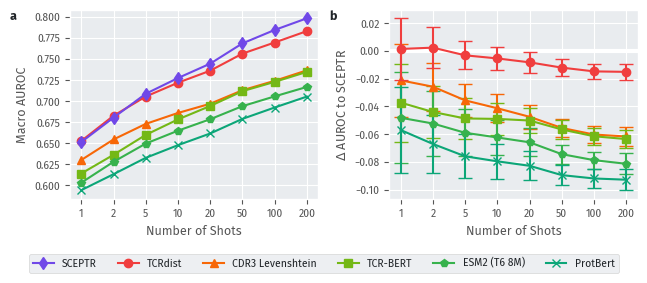

In [98]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "d-", 2)
comparisons = (
    ModelToPlot("TCRdist", "#f03e3e", "o-", 1.9),
    # ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f76707", "^-"),
    ModelToPlot("TCR-BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 6)
fig.savefig(f"shootout.{SAVE_FORMAT}", bbox_inches="tight")

In [189]:
def generate_ablation_figure(ks: Iterable[int], epitopes: Iterable[str]) -> Figure:
    sceptr = ModelToPlot("SCEPTR", "#7048e8", "d-", 2)

    mlm_only = ModelToPlot("SCEPTR (MLM only)", "#7048e8", "--")

    avg_pool = ModelToPlot("SCEPTR (average pooling)", "#7048e8", "--")

    synthetic_data = ModelToPlot("SCEPTR (synthetic data)", "#7048e8", "--")
    shuffled_data = ModelToPlot("SCEPTR (shuffled data)", "#7048e8", ":")

    cdr3_only = ModelToPlot("SCEPTR (CDR3 only)", "#b197fc", "-")
    cdr3_mlm_only = ModelToPlot("SCEPTR (CDR3 only, MLM only)", "#b197fc", "--")
    
    tcrdist = ModelToPlot("TCRdist", "#f03e3e", "o-")
    tcr_bert = ModelToPlot("TCR-BERT", "#74b816", "s-")

    fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(6.5,5.5))

    def plot_ablation(models: Iterable[ModelToPlot], axes: Axes) -> None:
        for model in models:
            raw_results = [model.load_data(get_ovr_task_name(k)) for k in ks]
            average_auc_per_epitope = [df.groupby("epitope").aggregate({"auc": "mean"}) for df in raw_results]
            avg_aucs = [s[s.index.isin(epitopes)].mean().item() for s in average_auc_per_epitope]

            axes.plot(avg_aucs, model.marker, c=model.colour, label=model.name, zorder=model.zorder)
        
        axes.set_xticks(range(len(ks)), ks)

        axes.legend(loc="upper center", bbox_to_anchor=(0,-0.25,1,0.1))

    plot_ablation([sceptr, mlm_only, tcrdist], axs[0][0])
    plot_ablation([sceptr, avg_pool, tcrdist], axs[0][1])
    plot_ablation([sceptr, synthetic_data, shuffled_data, tcrdist], axs[1][0])
    plot_ablation([sceptr, cdr3_only, cdr3_mlm_only, tcr_bert], axs[1][1])

    for ax, label in zip(axs[:,0], ("a", "c")):
        trans = ScaledTranslation(-50/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')
    
    for ax, label in zip(axs[:,1], ("b", "d")):
        trans = ScaledTranslation(-20/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')

    fig.supylabel("Macro AUROC")
    fig.supxlabel("Number of Shots")

    fig.tight_layout()

    return fig

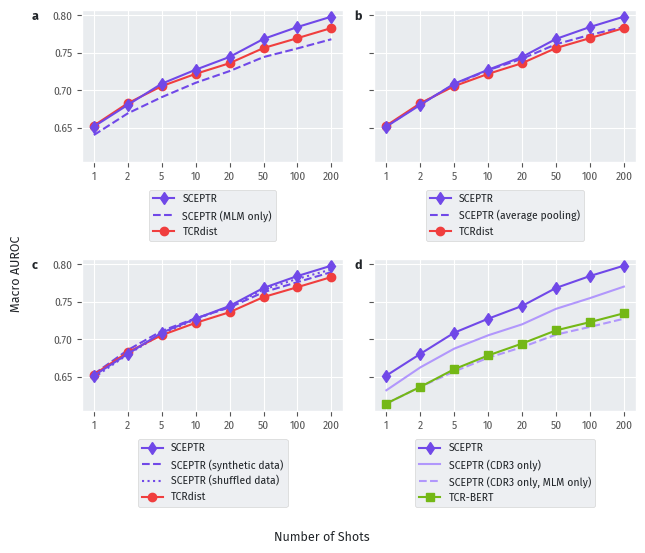

In [190]:
fig = generate_ablation_figure(NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig(f"ablation_multi.{SAVE_FORMAT}", bbox_inches="tight")

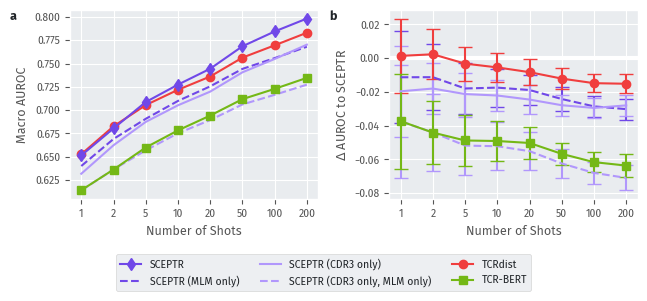

In [130]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "d-", 2)
comparisons = (
    ModelToPlot("SCEPTR (MLM only)", "#7048e8", "--"),
    ModelToPlot("SCEPTR (CDR3 only)", "#b197fc", "-"),
    ModelToPlot("SCEPTR (CDR3 only, MLM only)", "#b197fc", "--"),
    ModelToPlot("TCRdist", "#f03e3e", "o-"),
    ModelToPlot("TCR-BERT", "#74b816", "s-")
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 3)
fig.savefig(f"ablation.{SAVE_FORMAT}", bbox_inches="tight")

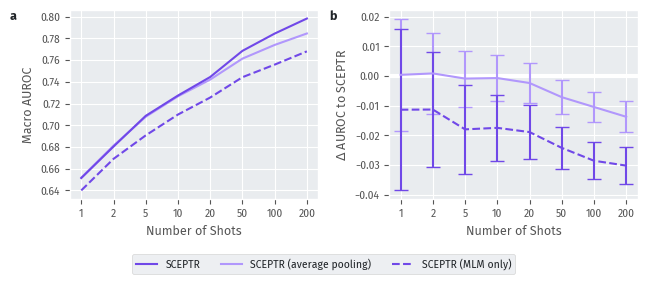

In [8]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "-", 2)
comparisons = (
    ModelToPlot("SCEPTR (average pooling)", "#b197fc", "-"),
    ModelToPlot("SCEPTR (MLM only)", "#7048e8", "--"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 3)
fig.savefig(f"cls_vs_avg_pool.{SAVE_FORMAT}", bbox_inches="tight")

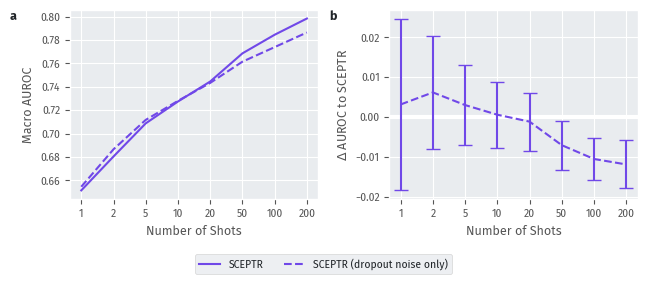

In [9]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "-")
comparisons = (
    ModelToPlot("SCEPTR (dropout noise only)", "#7048e8", "--"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 2)
fig.savefig(f"effect_of_noise.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "-", 2)
comparisons = (
    ModelToPlot("SCEPTR (OLGA)", "#b197fc", "-"),
    ModelToPlot("SCEPTR (unpaired)", "#7048e8", "--"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 3)
fig.savefig(f"data_ablation.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "-")
comparisons = (
    ModelToPlot("SCEPTR (classic)", "#7048e8", "--"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 2)
fig.savefig(f"simple_vs_classic.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
anchor = ModelToPlot("SCEPTR", "#7048e8", "d-", 2, ten_x=True)
comparisons = (
    ModelToPlot("TCRdist", "#f03e3e", "o-", 1.9, ten_x=True),
    ModelToPlot("CDR3 Levenshtein", "#f76707", "^-", ten_x=True),
    ModelToPlot("TCR-BERT", "#74b816", "s-", ten_x=True),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-", ten_x=True),
    ModelToPlot("ProtBert", "#0ca678", "x-", ten_x=True),
)

LARGELY_SAMPLED_EPITOPES = pd.read_csv("analysis_results/10x/CDR3 Levenshtein/one_vs_rest_200_shot_nn.csv").epitope.unique()

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, 6)
fig.savefig(f"shootout_with_10x.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
print(LARGELY_SAMPLED_EPITOPES)

In [ ]:
def plot_predetermined_split_results(models: Iterable[ModelToPlot], task: Literal["discrimination_ovr", "detection"]) -> Figure:
    aucs_per_model = []

    for model in models:
        if model.name == "SCEPTR (finetuned)":
            method = "avg_dist"
        else:
            method = "nn"
        aucs_per_model.append(model.load_data(f"{task}_predetermined_split_{method}").set_index("epitope"))
    
    for model, aucs in zip(models, aucs_per_model):
        aucs.columns = [model.name]
    
    aucs_per_model = pd.concat(aucs_per_model, axis="columns")
    aucs_per_model["avg"] = aucs_per_model.apply(lambda row: row.mean(), axis="columns")
    aucs_per_model = aucs_per_model.sort_values(by="avg", ascending=False)

    fig, ax = plt.subplots(figsize=(6.5,3))

    for model in models:
        ax.plot(aucs_per_model[model.name], model.marker, c=model.colour, label=model.name, zorder=model.zorder)

    ax.set_ylabel("AUROC")
    ax.set_xlabel("Epitope")
    # ax.tick_params(axis='x', labelrotation=90)

    ax.legend()
    fig.tight_layout()

    return fig

In [ ]:
models = (
    ModelToPlot("SCEPTR (finetuned)", "#5f3dc4", "P-", 2),
    ModelToPlot("SCEPTR", "#7048e8", "d-", 1.9),
    ModelToPlot("TCRdist", "#f03e3e", "o-", 1.8),
    # ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f76707", "^-"),
    ModelToPlot("TCR-BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = plot_predetermined_split_results(models, "discrimination_ovr")
fig.savefig(f"scl_discrimination.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
fig = plot_predetermined_split_results(models, "detection")
fig.savefig(f"scl_detection.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
def get_ovr_task_name(k: int) -> str:
    if k == 1:
        return "one_vs_rest_unseen_epitopes_1_shot"
    return f"one_vs_rest_unseen_epitopes_{k}_shot_nn"

LARGELY_SAMPLED_UNSEEN_EPITOPES = (
    "CINGVCWTV",
    "GLCTLVAML",
    "LLWNGPMAV",
    "ATDALMTGF",
    "QYIKWPWYI",
    "LTDEMIAQY",
)

NUM_SHOTS_OF_INTEREST = [1,2,5,10,20]

anchor = ModelToPlot("SCEPTR", "#7048e8", "d-", 2)
comparisons = (
    ModelToPlot("SCEPTR (finetuned)", "#5f3dc4", "P-", 2),
    ModelToPlot("TCRdist", "#f03e3e", "o-", 1.9),
    # ModelToPlot("CDR Levenshtein", "#f76707", "v-"),
    ModelToPlot("CDR3 Levenshtein", "#f76707", "^-"),
    ModelToPlot("TCR-BERT", "#74b816", "s-"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p-"),
    ModelToPlot("ProtBert", "#0ca678", "x-"),
)

fig = generate_ovr_summary_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_UNSEEN_EPITOPES, 4)
fig.savefig(f"scl_does_not_generalise.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
def plot_model_calibration() -> Figure:
    models = (
        ModelToPlot("SCEPTR", None, None),
        ModelToPlot("SCEPTR (classic)", None, None),
        ModelToPlot("TCR-BERT", None, None),
    )
    epc_insights_per_model = {model.name: model.load_epc_analyser().get_summary_df() for model in models}

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.5,2.5), sharex=True)

    position_array = np.arange(5) * 6
    errorbar_kwargs = {
        "fmt": "-",
        "capsize": 3,
    }

    for ax, model_name in zip(axs, epc_insights_per_model):
        epc_insights = epc_insights_per_model[model_name]

        ax.errorbar(position_array, epc_insights["ins"], yerr=epc_insights["ins_std"], label="insertion", c="#7048e8", **errorbar_kwargs)
        ax.errorbar(position_array+1, epc_insights["del"], yerr=epc_insights["del_std"], label="deletion", c="#f76707", **errorbar_kwargs)
        ax.errorbar(position_array+2, epc_insights["sub"], yerr=epc_insights["sub_std"], label="substitution", c="#37b24d", **errorbar_kwargs)
        ax.set_xticks(
            position_array+1, epc_insights.index.str.replace("_","-")
        )

        ax.set_title(model_name)

    axs[0].set_ylabel("distance")
    axs[1].set_xlabel("CDR3 region")

    # for ax, label in zip(axs, ("a", "b", "c")):
    #     trans = ScaledTranslation(-20/100, 30/100, fig.dpi_scale_trans)
    #     ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')
    
    fig.legend(*axs[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=3)
    fig.tight_layout()
    
    return fig

In [ ]:
fig = plot_model_calibration()
fig.savefig(f"calibration.{SAVE_FORMAT}", bbox_inches="tight")

In [ ]:
def generate_pgen_density_plot(model: ModelToPlot) -> Figure:
    pgen_nn_dists = model.load_data("pgen_nn_dists")
    log10_pgens = np.log10(pgen_nn_dists["pgen"])
    bins = range(-20, -14)
    bin_positions = range(len(bins) + 1)
    nn_dists_by_pgen = bin_dists_by_pgen(pgen_nn_dists["nn_dist"], log10_pgens, bins)

    fig, ax = plt.subplots()
    ax.boxplot(nn_dists_by_pgen, positions=bin_positions)

    bin_labels = ["$<10^{" + str(bins[0]) + "}$"]
    bin_labels += [
        "$10^{" + str(bins[i]) + "}-10^{" + str(bins[i + 1]) + "}$"
        for i in range(len(bins) - 1)
    ]
    bin_labels += ["$>10^{" + str(bins[-1]) + "}$"]

    ax.set_xticks(bin_positions)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right")

    fig.tight_layout()

def bin_dists_by_pgen(dists, pgens, bins) -> list:
    binned_data = [[] for _ in range(len(bins) + 1)]

    inds = np.digitize(pgens, bins)
    for value, ind in zip(dists, inds):
        binned_data[ind].append(value)

    return binned_data

In [ ]:
generate_pgen_density_plot(ModelToPlot("tcrdist", None, None))

In [ ]:
generate_pgen_density_plot(ModelToPlot("SCEPTR", None, None))